In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision
from torch.utils.data import DataLoader
import torch
from torchvision import datasets,transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [27]:
data_transforms = transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
image_datasets = {
    x: datasets.ImageFolder(root=f"archive/{x}", transform=data_transforms)
    for x in ['Training', 'Validation','Testing']
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['Training', 'Validation','Testing']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation','Testing']}

# Class labels
classes = ('glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor')
num_classes = len(classes)


In [28]:
model = models.resnet18(pretrained=True)
# Freeze early layers to retain pretrained weights
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer with a new layer that has `num_classes` outputs
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 10)

    for phase in ['Training', 'Validation']:
        if phase == 'Training':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'Training'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'Training':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    scheduler.step()

print("Training complete.")
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = 'model_{}'.format(timestamp)
torch.save(model.state_dict(), model_path)

glioma_tumor  pituitary_tumor  no_tumor  glioma_tumor


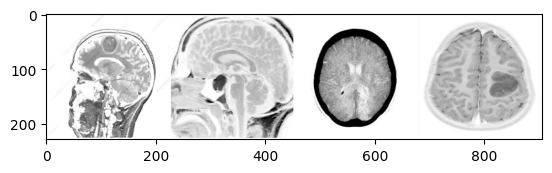

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(dataloaders['Testing'])
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [13]:
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  meningioma_tumor pituitary_tumor meningioma_tumor glioma_tumor


/var/folders/71/y1w_ptxd1m5b39p9kjdyys9h0000gn/T/ipykernel_54326/771851285.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['Testing']:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 43 %
